In [204]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

set_log_level("ERROR")

In [205]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.optimizers import Adam

In [206]:
# Get data
ds1 = pd.read_csv('../BBCA.JK.csv')
ds2 = pd.read_csv('../BBRI.JK.csv')
ds3 = pd.read_csv('../BMRI.JK.csv')

ds = ds3
ds.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-31,3800.0,3887.5,3775.0,3837.5,3051.898926,173453000
1,2019-06-03,3837.5,3837.5,3837.5,3837.5,3051.898926,0
2,2019-06-04,3837.5,3837.5,3837.5,3837.5,3051.898926,0
3,2019-06-05,3837.5,3837.5,3837.5,3837.5,3051.898926,0
4,2019-06-06,3837.5,3837.5,3837.5,3837.5,3051.898926,0


In [207]:
print(ds1['Date'].min())
print(ds1['Date'].max())
print(ds2['Date'].min())
print(ds2['Date'].max())
print(ds3['Date'].min())
print(ds3['Date'].max())

2019-05-31
2024-05-30
2019-05-31
2024-05-30
2019-05-31
2024-05-30


EDA

In [208]:
# Check for missing values from the datasets
print(len(ds))
print(len(ds2))
print(len(ds3))

print(ds.isnull().sum())
print(ds2.isnull().sum())
print(ds3.isnull().sum())

1215
1215
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


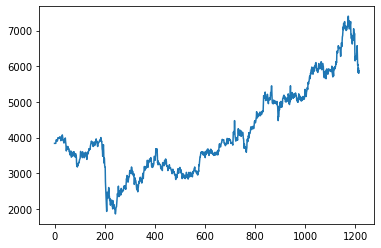

In [209]:
plt.plot(ds.Close)

In [210]:
# Check for missing value
print(ds.isnull().sum())
print(len(ds))

# Handle missing value if there's any with forward fill
ds.fillna(value='ffil', inplace=True)
print(ds.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [211]:
# Take date and close as dataset
ds = ds[['Date', 'Close']]
ds

,Date,Close
0,2019-05-31,3837.5
1,2019-06-03,3837.5
2,2019-06-04,3837.5
3,2019-06-05,3837.5
4,2019-06-06,3837.5
...,...,...
1210,2024-05-22,6050.0
1211,2024-05-27,5825.0
1212,2024-05-28,5950.0
1213,2024-05-29,5800.0


In [212]:
print(ds['Close'].min())
print(ds['Close'].max())

1860.0
7400.0


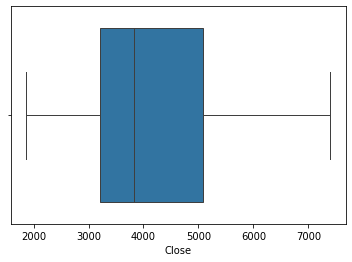

In [213]:
# Box plot to check for outliers
import seaborn as sns

sns.boxplot(x=ds['Close'])
plt.show()

# Proposed Ensemble NP-Trans

In [214]:
# Set dataset for neuralprophet by renaming the columns
ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})
ds_np

,ds,y
0,2019-05-31,3837.5
1,2019-06-03,3837.5
2,2019-06-04,3837.5
3,2019-06-05,3837.5
4,2019-06-06,3837.5
...,...,...
1210,2024-05-22,6050.0
1211,2024-05-27,5825.0
1212,2024-05-28,5950.0
1213,2024-05-29,5800.0


In [215]:
# # change data split size:
# test_size = -30
# valid_size = -495

# ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]
# train_len = len(ds_np_train)
# val_len = len(ds_np_val)
# total_train = train_len + val_len
# print(len(ds_np_train))
# print(len(ds_np_val))
# print(len(ds_np_test))

In [216]:
# Data split with ratio
test_ratio = 0.1
valid_ratio = 0.4

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))
valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

print(test_size)
print(valid_size)

# Split the dataset into training, validation, and test sets
ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

train_len = len(ds_np_train)
val_len = len(ds_np_val)
total_train = train_len + val_len

# Print lengths to verify
print(len(ds_np_train), len(ds_np_val), len(ds_np_test))

-122
-608
607 486 122


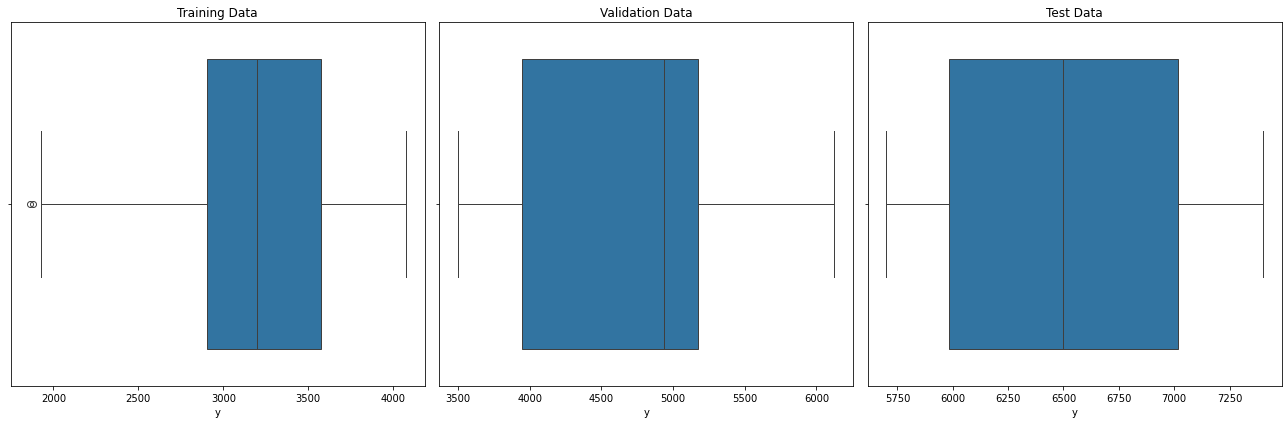

In [217]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# training data box plot
sns.boxplot(ax=axes[0], x=ds_np_train['y'])
axes[0].set_title('Training Data')

# validation data box plot
sns.boxplot(ax=axes[1], x=ds_np_val['y'])
axes[1].set_title('Validation Data')

# test data box plot
sns.boxplot(ax=axes[2], x=ds_np_test['y'])
axes[2].set_title('Test Data')

# # Set a common y-label
# fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

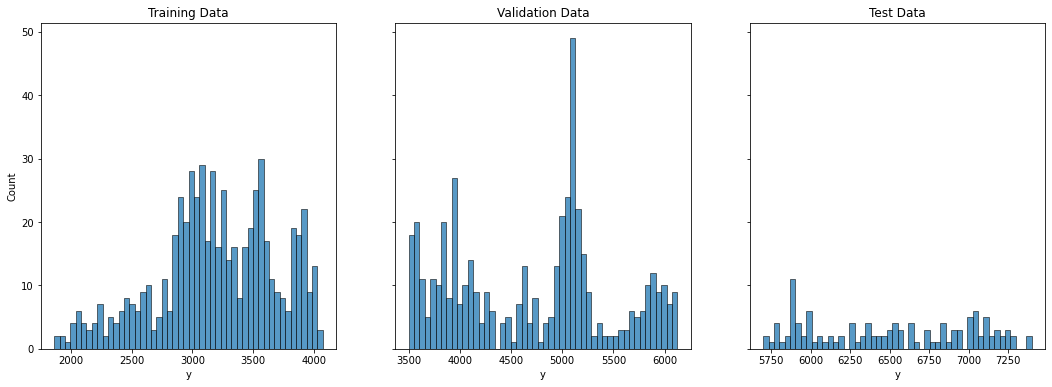

In [218]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(ds_np_train['y'], ax=axes[0], bins=50)
axes[0].set_title('Training Data')

sns.histplot(ds_np_val['y'], ax=axes[1], bins=50)
axes[1].set_title('Validation Data')

sns.histplot(ds_np_test['y'], ax=axes[2], bins=50)
axes[2].set_title('Test Data')

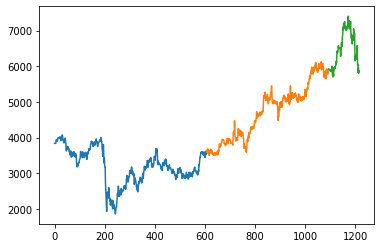

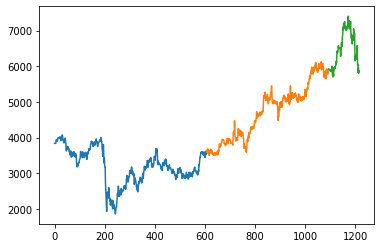

In [219]:
# plt.subplot(1, 2, 1)
plt.plot(ds.Close[:valid_size])
plt.plot(ds.Close[valid_size:test_size])
plt.plot(ds.Close[test_size:])
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(ds_np_train.y)
plt.plot(ds_np_val.y)
plt.plot(ds_np_test.y)

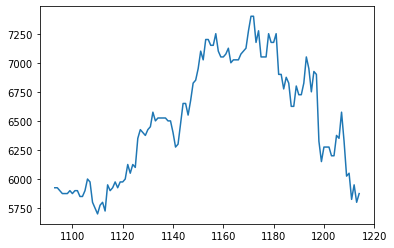

variance: 248065.98021948244
standar deviation: 498.0622252484949
mean: 6505.737704918033
cv: 0.07655737870771875


In [220]:
# Check variance of the dataset (is this the reason of the bad R2)
plt.plot(ds.Close[test_size:])
plt.show()

# plt.plot(ds_np_test.y)

variance = ds.Close[test_size:].var()
std = ds.Close[test_size:].std()
mean = ds.Close[test_size:].mean()
print(f'variance: {variance}')
print(f'standar deviation: {std}')
print(f'mean: {mean}')
print(f'cv: {std/mean}')

## NeuralProphet

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 240.71it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 1323.67it/s, loss=0.0022, v_num=342, MAE_val=71.30, RMSE_val=95.90, Loss_val=0.00359, RegLoss_val=0.000, MAE=65.20, RMSE=86.90, Loss=0.00222, RegLoss=0.000]   


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,1703.057251,2122.873779,0.686135,0.0,0,2699.193359,3337.369873,0.819763,0.0
1,1195.984985,1519.669678,0.447518,0.0,1,1881.088501,2359.881104,0.532666,0.0
2,798.775757,1031.398193,0.264280,0.0,2,1437.166870,1806.168945,0.385918,0.0
3,552.279175,713.917847,0.153743,0.0,3,997.559509,1276.677856,0.234630,0.0
4,376.413544,480.184296,0.081762,0.0,4,694.756653,899.665100,0.141157,0.0
...,...,...,...,...,...,...,...,...,...
125,71.360886,96.120552,0.003611,0.0,125,66.321426,87.712616,0.002285,0.0
126,71.607895,96.240005,0.003620,0.0,126,66.510704,88.817116,0.002309,0.0
127,71.852570,96.389183,0.003631,0.0,127,63.527512,85.162399,0.002192,0.0
128,71.658371,96.209549,0.003618,0.0,128,65.398598,87.655777,0.002220,0.0


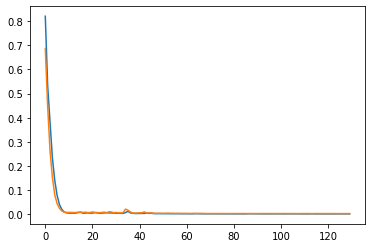

In [221]:
# Set NP model
n_lags = 2

np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = np_model.fit(ds_np_train, validation_df=ds_np_val, progress="plot")
metrics

In [222]:
# Generate prediction with val data (used to train meta model)
forecast = np_model.predict(ds_np_val)
# forecast

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


In [223]:
metrics_test = np_model.test(ds_np_val)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0035939915105700493   │
│          MAE_val          │     71.3038330078125      │
│         RMSE_val          │     95.89242553710938     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [224]:
np_model.plot(forecast)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [225]:
np_model.plot_components(forecast)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [226]:
forecast

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2021-11-17,3612.5,NaN,NaN,NaN,NaN,NaN
1,2021-11-18,3587.5,NaN,NaN,NaN,NaN,NaN
2,2021-11-19,3625.0,3620.836914,-53.907551,3086.327148,222.606415,365.810760
3,2021-11-22,3675.0,3590.866211,-79.674820,3090.702881,231.536667,348.301331
4,2021-11-23,3575.0,3645.514648,-43.663147,3092.161133,234.549820,362.466766
...,...,...,...,...,...,...,...
515,2023-11-08,5850.0,5926.926758,1248.663208,4134.967773,179.196442,364.099487
516,2023-11-09,5875.0,5871.514648,1182.340454,4136.425781,184.137802,368.610382
517,2023-11-10,5775.0,5846.358398,1153.898071,4137.884766,188.792221,365.783661
518,2023-11-13,5825.0,5847.898926,1156.353394,4142.260254,201.166000,348.119446


In [227]:
print(f"MAE: {mean_absolute_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")

MAE: 71.30383303025602
RMSE: 95.89241700835309
R2: 0.9840141946069942


In [228]:
# Check test data (not used)

# forecast_test = np_model.predict(ds_np_test)
# metrics_test2 = np_model.test(ds_np_test)

# np_model.plot(forecast_test)

# np_model.plot_components(forecast_test)

# print(f"MAE: {mean_absolute_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"RMSE: {root_mean_squared_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"R2: {r2_score(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")

## Transformer

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import tensorflow as tf
from keras import layers
# from keras.layers import MultiHeadAttention, 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [230]:
# close_prices = ds['Close'].values.reshape(-1,1)
# scler = MinMaxScaler()
# close_prices = scler.fit_transform(close_prices)

In [231]:
# Define window size and number of features
window_size = 10
num_features = 1  # close price

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train, x_val, x_test = X[:valid_size], X[valid_size:test_size], X[test_size:]
y_train, y_val, y_test = y[:valid_size], y[valid_size:test_size], y[test_size:]

print(len(x_train), len(x_val), len(x_test))
print(len(y_train), len(y_val), len(y_test))
print(x_train.shape)
print(y_train.shape)

597 486 122
597 486 122
(597, 10)
(597,)


In [232]:
x_train[0]

array([3837.5, 3837.5, 3837.5, 3837.5, 3837.5, 3837.5, 3925. , 3937.5,
       3937.5, 3912.5])

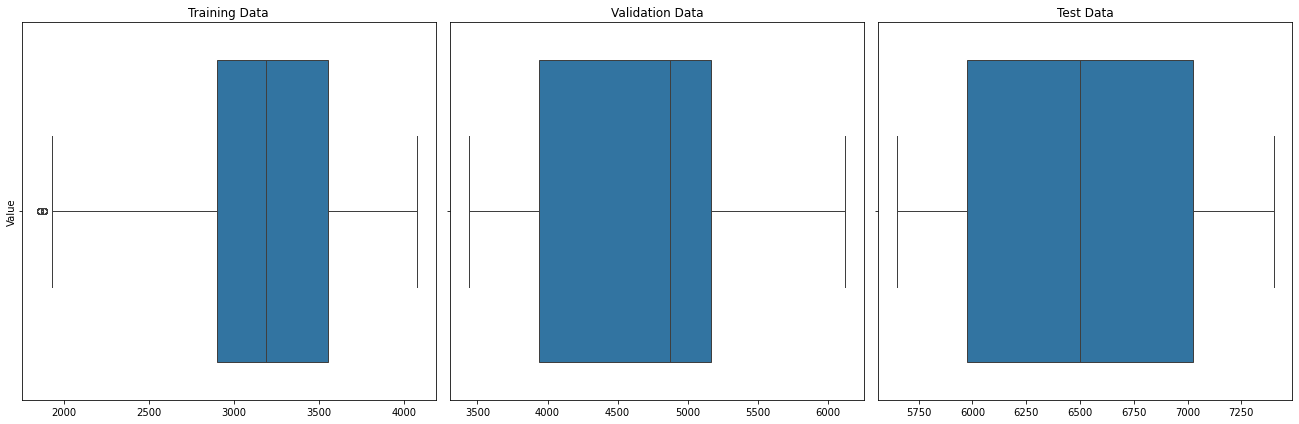

In [233]:
# plt.plot(x_train.flatten(), label='Training Data')
# plt.legend()
# plt.show()

# Outlier detection
# Flatten the data to make it suitable for plotting with boxplot
x_train_flat = x_train.flatten()
x_val_flat = x_val.flatten()
x_test_flat = x_test.flatten()

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Create a box plot for the training data
sns.boxplot(ax=axes[0], x=x_train_flat)
axes[0].set_title('Training Data')

# Create a box plot for the validation data
sns.boxplot(ax=axes[1], x=x_val_flat)
axes[1].set_title('Validation Data')

# Create a box plot for the test data
sns.boxplot(ax=axes[2], x=x_test_flat)
axes[2].set_title('Test Data')

# Set a common y-label
fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

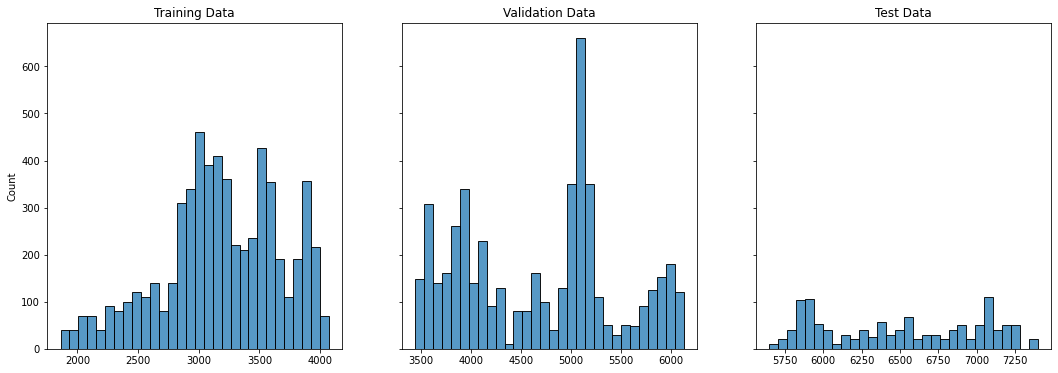

In [234]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(x_train_flat, ax=axes[0], bins=30)
axes[0].set_title('Training Data')

sns.histplot(x_val_flat, ax=axes[1], bins=30)
axes[1].set_title('Validation Data')

sns.histplot(x_test_flat, ax=axes[2], bins=30)
axes[2].set_title('Test Data')

In [235]:
# Tried adding normalization to solve the bad R2 score when predicting the test set
# Result: adding normalization result in worse evaluation seen from the MAE, RMSE, and R2

# # Normalize the data using MinMaxScaler
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(-1, window_size, num_features)


In [236]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  # n_timesteps, n_features, n_outputs = 5, 1, 5 
  inputs = tf.keras.Input(shape=(window_size, num_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(1, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

# transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)
transformer = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)

# transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     metrics=["mae", 'mape'],
# )
transformer.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [237]:
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'position': self.pos_encoding.shape[0],
            'd_model': self.pos_encoding.shape[1],
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [238]:
# def transformer_encoder2(inputs, head_size, num_heads, ff_dim,
#                         dropout=0):
#   x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#   x = layers.MultiHeadAttention(
#       key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#   x = layers.Dropout(dropout)(x)
#   res = x + inputs
  
#   # Feed Forward Part
#   x = layers.LayerNormalization(epsilon=1e-6)(res)
#   x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#   x = layers.Dropout(dropout)(x)
#   x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#   return x + res

# def build_transfromer2(head_size, 
#                       num_heads,
#                       ff_dim,
#                       num_trans_blocks,
#                       mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
#   inputs = tf.keras.Input(shape=(window_size, num_features))
#   x = PositionalEncoding(window_size,num_features)(inputs) 
#   for _ in range(num_trans_blocks):
#     x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
#   x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#   for dim in mlp_units:
#     x = layers.Dense(dim, activation="relu")(x)
#     x = layers.Dropout(mlp_dropout)(x)

#   outputs = layers.Dense(1, activation='linear')(x)
#   return tf.keras.Model(inputs, outputs)

# transformer2 = build_transfromer2(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)

# # transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
# #     metrics=["mae", 'mape'],
# # )
# transformer2.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [239]:
histT = transformer.fit(x_train, y_train, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 5928969.5000 - mae: 2068.2922 - mape: 64.5340

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 5773811.5000 - mae: 2031.8903 - mape: 63.4113
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 480398.1250 - mae: 561.7245 - mape: 17.6193
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 170765.4219 - mae: 323.2299 - mape: 10.1958
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 143119.0625 - mae: 283.1736 - mape: 8.9391
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 126454.2500 - mae: 283.2971 - mape: 9.1325
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 124561.9062 - mae: 286.6026 - mape: 9.2171
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 118142.3750 - mae: 266.9168 - mape: 8.4875
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 96724.8672 - mae: 242.4143 - mape: 7.7083
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 97321.3281 - mae: 236.9893 - mape: 7.6515
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 116964.4297 - mae: 

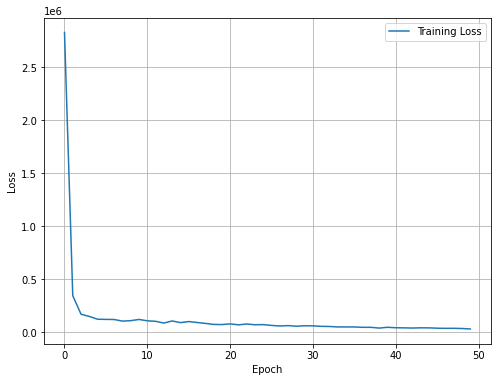

In [240]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT.history['loss'], label='Training Loss')
# plt.plot(histT.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [241]:
# histT2 = transformer2.fit(x_train, y_train, batch_size=32, epochs=50,
#                          verbose=1, callbacks=callbacks)

In [242]:
prediction = transformer.predict(x_val)
# prediction2 = transformer2.predict(x_val)

print("TRANSFORMER EVALUATION METRICS")
# mse1 = np.mean((prediction - y_val)**2)
# rmse1 = np.sqrt(mse1)
# mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# print('MSE: ', mse1)
# print('RMSE: ', rmse1)
# print('MAPE: ', mape)

print(f"MAE: {mean_absolute_error(prediction, y_val)}")
print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# # print(f"MSE: {mean_squared_error(prediction2, y_val)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
TRANSFORMER EVALUATION METRICS
MAE: 66.35477551118827
RMSE: 92.24259463867632
R2: 0.9862473841648461


##### testing stuff

In [243]:
# predTrain = transformer.predict(x_train)

# print(f"MAE: {mean_absolute_error(predTrain, y_train)}")
# print(f"RMSE: {root_mean_squared_error(predTrain, y_train)}")
# print(f"R2: {r2_score(predTrain, y_train)}")
# print(f"R2: {mean_squared_error(predTrain, y_train)}")

In [244]:
# # prediction = scler.inverse_transform(prediction)
# # prediction2 = scler.inverse_transform(prediction2)

# print("TRANSFORMER EVALUATION METRICS")
# # mse1 = np.mean((prediction - y_val)**2)
# # rmse1 = np.sqrt(mse1)
# # mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# # print('MSE: ', mse1)
# # print('RMSE: ', rmse1)
# # print('MAPE: ', mape)

# print(f"MAE: {mean_absolute_error(prediction, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
# print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# print(f"MSE: {mean_squared_error(prediction2, y_val)}")

In [245]:
# Check test data (not used)

# testPrd = transformer.predict(x_test)
# testPrd2 = transformer2.predict(x_test)

# print(f"MAE: {mean_absolute_error(testPrd, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd, y_test)}")
# print(f"R2: {r2_score(testPrd, y_test)}")

# print(f"MAE: {mean_absolute_error(testPrd2, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd2, y_test)}")
# print(f"R2: {r2_score(testPrd2, y_test)}")

# plt.plot(y_test, 'g')
# plt.plot(testPrd, 'b')
# plt.plot(testPrd2, 'r')
# # plt.plot(forecast['yhat1'], 'y')
# plt.legend(['Actual', 'Prediction Transformer', 'Pred Transformer2'])

# print(np.mean(y_test))
# print(np.mean(testPrd))

### Transformer graph and result

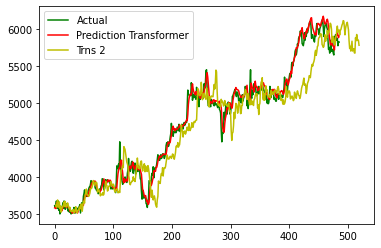

In [246]:
plt.plot(y_val, 'g')
plt.plot(prediction, 'r')
# plt.plot(prediction2, 'b')
plt.plot(forecast['yhat1'], 'y')
plt.legend(['Actual', 'Prediction Transformer', 'Trns 2', 'NP'])

# notes: the neuralprophet prediction is more compared to the actual and transformer as there are inputs of data from the model itself

# Stack/Hybrid

In [247]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [248]:
# Combine data prediction result of base models
np_pred = forecast[forecast['ds'].isin(ds_np_val['ds'])].reset_index()
np_pred = np_pred['yhat1']

x_train_meta = np.column_stack((np_pred[n_lags:], prediction[n_lags:]))

In [249]:
print(f"train: {x_train_meta[:10]}")
print(f"label: {y_val[:10]}")

train: [[3620.837  3572.3552]
 [3590.8662 3614.7368]
 [3645.5146 3654.948 ]
 [3688.772  3610.878 ]
 [3590.9072 3591.8462]
 [3595.6382 3633.7104]
 [3662.4329 3603.8125]
 [3572.947  3586.9165]
 [3604.8071 3552.0476]
 [3524.1147 3563.8098]]
label: [3612.5 3587.5 3625.  3675.  3575.  3575.  3675.  3550.  3587.5 3500. ]


In [250]:
# Set meta model
meta_model = LinearRegression()
# meta_model = RandomForestRegressor(n_estimators=2)
print('Linear Regression Train')
meta_model.fit(x_train_meta, y_val[n_lags:])


meta_model2 = Sequential()
meta_model2.add(Dense(8, input_dim=x_train_meta.shape[1], activation='relu'))
meta_model2.add(Dropout(0.1))
meta_model2.add(Dense(16, activation='relu'))
# meta_model2.add(Dropout(0.2))
meta_model2.add(Dense(1, activation='linear'))
print('MLP Train')
meta_model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
meta_model2.fit(x_train_meta, y_val[n_lags:], epochs=20, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)

# meta_model3 = LogisticRegression(random_state=0)
# meta_model3.fit(x_train_meta, y_val[n_lags:])

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Linear Regression Train
MLP Train
Epoch 1/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 635ms/step - loss: 17985060.0000 - mae: 4178.2451 - mape: 85.2402

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - loss: 15559529.0000 - mae: 3884.4478 - mape: 82.4287
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 11567815.0000 - mae: 3346.9009 - mape: 71.1612
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 7869576.0000 - mae: 2745.8745 - mape: 58.6944
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 5124387.0000 - mae: 2156.9280 - mape: 45.6419
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 2540213.7500 - mae: 1402.9521 - mape: 29.5521
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1440170.2500 - mae: 830.9125 - mape: 17.5870
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 784440.4375 - mae: 399.9111 - mape: 8.7223
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 882155.9375 - mae: 565.4477 - mape: 12.0431
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 707966.3750 - mae: 501.8312 - mape: 10.6602
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 90

#### Final Prediction

In [251]:
# Use test data to make final prediction
# make prediction with base model
np_y_pred = np_model.predict(ds_np_test)
tf_y_pred = transformer.predict(x_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 479.51it/s]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [252]:
# Combine test data
np_y_pred = np_y_pred[np_y_pred['ds'].isin(ds_np_test['ds'])].reset_index()
np_y_pred = np_y_pred['yhat1']

x_test_meta = np.column_stack((np_y_pred[n_lags:], tf_y_pred[n_lags:]))

In [253]:
# Predict test data with meta model
final_pred = meta_model.predict(x_test_meta)
final_pred2 = meta_model2.predict(x_test_meta)
# final_pred3 = meta_model3.predict(x_test_meta)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [254]:
print(range(train_len, len(ds)-n_lags))
print(len(ds))
print(val_len)
print(len(y_test[n_lags:]))

range(607, 1213)
1215
486
120


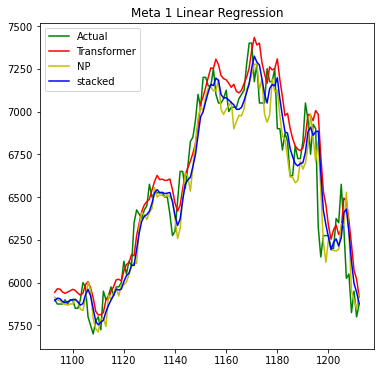

In [255]:
# Plot Prediction
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='stacked')
plt.title('Meta 1 Linear Regression')
plt.legend()

In [256]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 107.3724853515625
RMSE: 147.11832680564837
R2: 0.9020775452241268
Transformer Evaluation
MAE: 122.33924153645833
RMSE: 167.06878771667866
R2: 0.887317020280735
Meta Evaluation
MAE: 101.41938883463541
RMSE: 143.47823469789535
R2: 0.9104012868358058


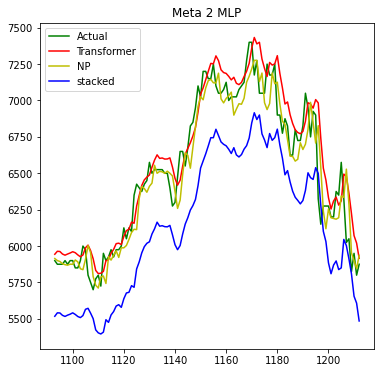

In [257]:
# Plot Predictions
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred2, 'b', label='stacked')
plt.title('Meta 2 MLP')
plt.legend()

In [258]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")
print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")
print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred2, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred2, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred2, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 107.3724853515625
RMSE: 147.11832680564837
R2: 0.9020775452241268
Transformer Evaluation
MAE: 122.33924153645833
RMSE: 167.06878771667866
R2: 0.887317020280735
Meta Evaluation
MAE: 391.2558186848958
RMSE: 414.23119857751277
R2: 0.21012513483613038


### Single Models

## Single NP

In [259]:
# Data split with ratio
test_ratio = 0.1

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))

# Split the dataset into training, validation, and test sets
ds_np_train2, ds_np_test2 = ds_np[:test_size], ds_np[test_size:]

print(len(ds_np_train2), len(ds_np_test2))

1093 122


Finding best initial lr: 100%|██████████| 227/227 [00:00<00:00, 253.24it/s]


Epoch 110: 100%|██████████| 110/110 [00:00<00:00, 795.42it/s, loss=0.000756, v_num=343, MAE=70.40, RMSE=94.60, Loss=0.000742, RegLoss=0.000]   


,MAE,RMSE,Loss,RegLoss,epoch
0,5361.973633,6455.243164,0.858002,0.0,0
1,3134.897949,3644.252441,0.466239,0.0,1
2,1900.490723,2150.895996,0.250014,0.0,2
3,1073.598145,1213.338379,0.106564,0.0,3
4,495.826752,570.888855,0.026486,0.0,4
...,...,...,...,...,...
105,69.891960,92.908287,0.000738,0.0,105
106,70.148972,94.448975,0.000744,0.0,106
107,70.549500,95.298759,0.000747,0.0,107
108,70.674217,94.430801,0.000744,0.0,108


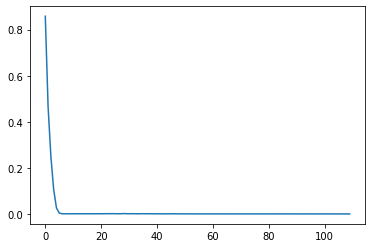

In [260]:
n_lags = 2

single_np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = single_np_model.fit(ds_np_train2, progress="plot")
metrics

In [261]:
forecast2 = np_model.predict(ds_np_test2)
forecast2

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2023-11-15,5925.0,NaN,NaN,NaN,NaN,NaN
1,2023-11-16,5925.0,NaN,NaN,NaN,NaN,NaN
2,2023-11-17,5900.0,5914.360352,1186.140869,4148.093750,214.912842,365.212708
3,2023-11-20,5875.0,5900.144043,1175.340942,4152.469238,224.094711,348.239166
4,2023-11-21,5875.0,5894.031738,1150.475952,4153.927734,227.081635,362.545807
...,...,...,...,...,...,...,...
137,2024-05-24,5900.0,6027.947266,1657.525391,4423.745117,-418.071625,364.748077
138,2024-05-27,5825.0,5952.802734,1573.025024,4428.120117,-397.231537,348.888550
139,2024-05-28,5950.0,5899.272461,1496.310425,4429.578613,-389.166199,362.549683
140,2024-05-29,5800.0,5845.671875,1431.424194,4431.037109,-380.615265,363.825653


In [262]:
np_model.plot_components(forecast2)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [263]:
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

MAE: 101.64296476403062
RMSE: 141.60628213490656
R2: 0.9156747599640688


## Single Trans

In [264]:
# Define window size and number of features
window_size = 10
num_features = 1

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train2, x_test2 = X[:test_size], X[test_size:]
y_train2, y_test2 = y[:test_size], y[test_size:]

# standarization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train2 = scaler_X.fit_transform(x_train2)
y_train2 = scaler_y.fit_transform(y_train2.reshape(-1, 1)).flatten()

# Use the same transformation on the test data
x_test2 = scaler_X.transform(x_test2)
y_test2 = scaler_y.transform(y_test2.reshape(-1, 1)).flatten()


In [265]:
transformer2 = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)


transformer2.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [266]:
histT2 = transformer2.fit(x_train2, y_train2, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

prediction2 = transformer2.predict(x_test2)


Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.4871 - mae: 0.5228 - mape: 91.9007

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.4842 - mae: 0.5212 - mape: 91.7857
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.1226 - mae: 0.2617 - mape: 57.0407
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0342 - mae: 0.1308 - mape: 55.2977
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0254 - mae: 0.1150 - mape: 57.7435
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0289 - mae: 0.1221 - mape: 52.7437
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0289 - mae: 0.1229 - mape: 50.5012
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0239 - mae: 0.1137 - mape: 53.9615
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0252 - mae: 0.1152 - mape: 51.4985
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0240 - mae: 0.1121 - mape: 49.6918
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0268 - mae: 0.1186 - mape: 59.6930
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/st

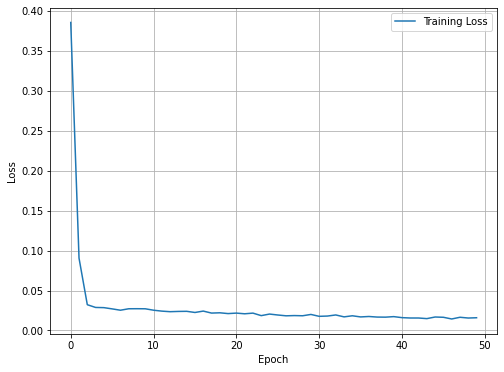

In [267]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT2.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [268]:
prediction2 = prediction2.reshape(-1, 1)
prediction2 = scaler_y.inverse_transform(prediction2)

y_test2 = scaler_y.inverse_transform(y_test2.reshape(-1, 1))

print("TRANSFORMER EVALUATION METRICS")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

TRANSFORMER EVALUATION METRICS
MAE: 114.25776447233606
RMSE: 152.04940334144
R2: 0.8992623082276753


In [269]:
print("Evaluation metrics between models of:")
print("\nProposed Ensemble Np-Trans")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

print("\nNeuralProphet")
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

print("\nTransformer")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

Evaluation metrics between models of:

Proposed Ensemble Np-Trans
MAE: 101.41938883463541
RMSE: 143.47823469789535
R2: 0.9104012868358058

NeuralProphet
MAE: 101.64296476403062
RMSE: 141.60628213490656
R2: 0.9156747599640688

Transformer
MAE: 114.25776447233606
RMSE: 152.04940334144
R2: 0.8992623082276753


In [270]:
# the result of neuralprohet has some additional data of dates, so we will take only the date that's on the y
forecast2 = forecast2[forecast2['ds'].isin(ds_np_test2['ds'])].reset_index()


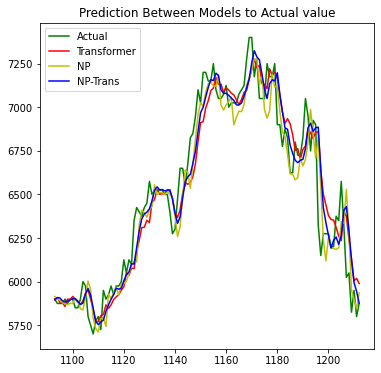

In [271]:
# Plot Prediction

fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test2[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), prediction2[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), forecast2['yhat1'][n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='NP-Trans')
plt.title('Prediction Between Models to Actual value')
plt.legend()

In [272]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 107.3724853515625
RMSE: 147.11832680564837
R2: 0.9020775452241268
Transformer Evaluation
MAE: 122.33924153645833
RMSE: 167.06878771667866
R2: 0.887317020280735
Meta Evaluation
MAE: 101.41938883463541
RMSE: 143.47823469789535
R2: 0.9104012868358058


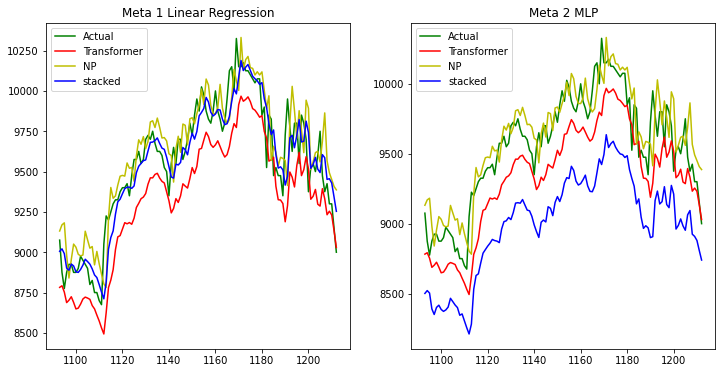

In [196]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

# Plot Prediction
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='stacked')
plt.title('Meta 1 Linear Regression')
plt.legend()

plt.subplot(1,2,2)
# Plot Predictions
# fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred2, 'b', label='stacked')
plt.title('Meta 2 MLP')
plt.legend()

plt.show()

# Tidy

In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

set_log_level("ERROR")

import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.optimizers import Adam
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression

c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
def data_process(ds):
    ds.fillna(value='ffil', inplace=True)
    ds = ds[['Date', 'Close']]

    ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})

    # Data split with ratio
    test_ratio = 0.1
    valid_ratio = 0.4

    # Calculate size of split based on ratio
    test_size = -1 * round(test_ratio * len(ds_np))
    valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

    # Split the dataset into training, validation, and test sets
    ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

    train_len = len(ds_np_train)
    val_len = len(ds_np_val)
    total_train = train_len + val_len

    # Print lengths to verify
    print(len(ds_np_train), len(ds_np_val), len(ds_np_test))
    return ds_np_train, ds_np_val, ds_np_test, test_size, valid_size

def data_process_2(ds, window_size, num_features):
    # make input sequences
    X = []
    y = []
    for i in range(len(ds['Close']) - window_size):
        X.append(ds['Close'][i:i+window_size])
        y.append(ds['Close'][i+window_size])

    # lists to arrays
    X, y = np.array(X), np.array(y)

    x_train, x_val, x_test = X[:valid_size], X[valid_size:test_size], X[test_size:]
    y_train, y_val, y_test = y[:valid_size], y[valid_size:test_size], y[test_size:]

    print(len(x_train), len(x_val), len(x_test))
    print(len(y_train), len(y_val), len(y_test))
    print(x_train.shape)
    print(y_train.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

def data_process_3(np_y_pred, tf_y_pred, n_lags, ds_np, np_flag):
    print("before processing np_pred")
    print(np.shape(np_y_pred))
    np_pred = np_y_pred[np_y_pred['ds'].isin(ds_np['ds'])].reset_index()
    np_pred = np_pred['yhat1']
    print("function:")
    print(np.shape(np_pred))
    print(np.shape(tf_y_pred))
    x_train_meta = np.column_stack((np_pred[n_lags:], tf_y_pred[n_lags:]))

    if np_flag == 0:
        return x_train_meta
    else:
        return x_train_meta, np_pred

In [3]:
def base_model_np(n_lags, ds_np_train, ds_np_val):
  np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
  )

  # Train NP 
  metrics = np_model.fit(ds_np_train, validation_df=ds_np_val, progress="plot")
  metrics

  return np_model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  # Creates a single transformer block.
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  
  # Creates final model by building many transformer blocks.
  
  inputs = tf.keras.Input(shape=(window_size, num_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(1, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

def base_model_tf(x_train, y_train, n_batch_size, n_epochs):
  transformer = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)

  transformer.compile(loss="mse", optimizer="adam", metrics=["mae", "mape"])
  callbacks = EarlyStopping(patience=10, restore_best_weights=True)

  history = transformer.fit(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs, verbose=1, callbacks=callbacks)

  return transformer

In [4]:
def graph_np_trans(total_len, ds, n_lags, y_test, np_y_pred, tf_y_pred, final_pred, stock_name):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(range(total_len, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
    plt.plot(range(total_len, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer Base")
    plt.plot(range(total_len, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP Base')
    plt.plot(range(total_len, len(ds)-n_lags), final_pred, 'b', label='Meta')
    plt.title(f'Meta vs Base Prediction of {stock_name}')
    plt.legend()
    plt.show()

In [5]:
def graph_np_trans2(axis, total_len, ds, n_lags, y_test, np_y_pred, tf_y_pred, final_pred, stock_name):
    axis.plot(range(total_len, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
    axis.plot(range(total_len, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer Base")
    axis.plot(range(total_len, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP Base')
    axis.plot(range(total_len, len(ds)-n_lags), final_pred, 'b', label='Meta')
    # axis.title(f'Meta vs Base Prediction of {stock_name}')
    axis.set_title(stock_name)

In [6]:
def evaluate(y_test, np_y_pred, tf_y_pred, final_pred, n_lags, stock_name):
    print(f'Evaluation results of {stock_name}')

    print('Neural Prophet Evaluation')
    print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")

    print('Transformer Evaluation')
    print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

    print('Meta Evaluation')
    print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
    print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

607 486 122


Finding best initial lr: 100%|██████████| 221/221 [00:01<00:00, 171.95it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.85it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5684336.5000 - mae: 2016.8873 - mape: 32.1507

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape
  current = self.get_monitor_value(logs)



19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 5403705.5000 - mae: 1953.6876 - mape: 31.1526
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 589607.7500 - mae: 618.7433 - mape: 9.9228
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 387063.1875 - mae: 497.0849 - mape: 8.1034
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 322237.3438 - mae: 451.3982 - mape: 7.2373
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 306887.3125 - mae: 436.5803 - mape: 7.0183
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 339391.6562 - mae: 466.1531 - mape: 7.4890
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 290805.9688 - mae: 441.3554 - mape: 7.1532
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 263259.4062 - mae: 412.2980 - mape: 6.5916
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 270329.8438 - mae: 414.6272 - mape: 6.6544
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 265402.5312 - mae: 404.3251 - 

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 245.49it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.47it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 4816792.0000 - mae: 1871.6379 - mape: 52.1452

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape
  current = self.get_monitor_value(logs)



19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 4570475.5000 - mae: 1809.6836 - mape: 50.4131
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 349434.2188 - mae: 472.4093 - mape: 13.4571
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 173302.0000 - mae: 329.6811 - mape: 9.1832
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 178828.7031 - mae: 334.2372 - mape: 9.5583
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 175593.8906 - mae: 328.1868 - mape: 9.1889
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 144807.0938 - mae: 304.4236 - mape: 8.5554
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 154398.9062 - mae: 303.2007 - mape: 8.6132
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 143510.1250 - mae: 310.4418 - mape: 8.7436
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 170629.2656 - mae: 330.2656 - mape: 9.3353
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 135692.3750 - mae: 292.9368 -

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 237.58it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.09it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1890088.8750 - mae: 1156.5680 - mape: 35.8448

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape
  current = self.get_monitor_value(logs)



19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 1844429.8750 - mae: 1138.9128 - mape: 35.3167
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 151911.0469 - mae: 299.6585 - mape: 9.4883
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 104978.5469 - mae: 252.5036 - mape: 8.1724
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 101329.1797 - mae: 249.2146 - mape: 7.9401
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 97755.1875 - mae: 246.7488 - mape: 7.7913
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 101905.0000 - mae: 254.5799 - mape: 8.3687
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 101233.2656 - mae: 252.9825 - mape: 8.1143
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 78725.1641 - mae: 223.0510 - mape: 7.1382
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 73578.8594 - mae: 213.6391 - mape: 6.9689
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 91593.9141 - mae: 226.9526 - mape

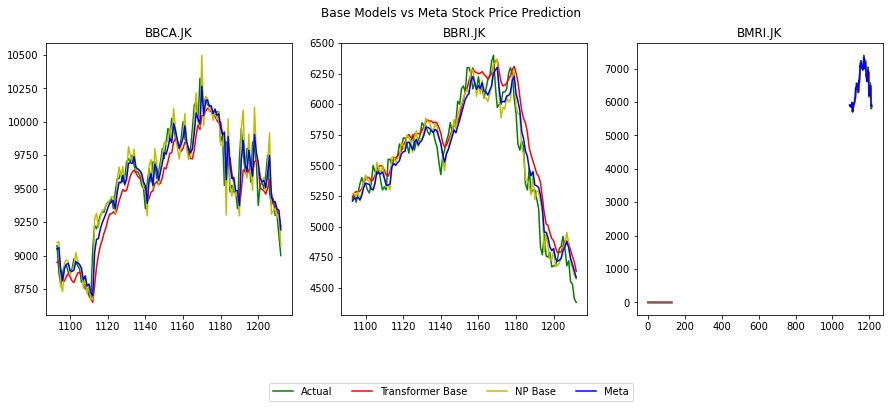

In [8]:
np_base_results = []
tf_base_results = []
meta_results = []

ds_list = ['BBCA.JK', 'BBRI.JK','BMRI.JK']
# ds_list = ['BBRI.JK','BMRI.JK']

fig, axes = plt.subplots(1, len(ds_list), figsize=(15,5), sharey=False)
fig.suptitle('Base Models vs Meta Stock Price Prediction')

for idx, i in enumerate(ds_list):
    ds = pd.read_csv(f'../{i}.csv')

    # Neural Prpohet Base Model
    np_train, np_val, np_test, test_size, valid_size = data_process(ds)
    
    total_train_len = len(np_train) + len(np_val)

    n_lags = 2
    np_base = base_model_np(n_lags, np_train, np_val)
    np_base_predict = np_base.predict(np_val)

    # Transformer Base Model
    window_size = 10
    num_features = 1
    tf_x_train, tf_x_val, tf_x_test, tf_y_train, tf_y_val, tf_y_test = data_process_2(ds, window_size, num_features)

    # head_size = 40
    # num_heads = 60
    # ff_dim = 60
    # num_trans_block = 4 
    # mlp_units = 256

    batch_size = 32
    epochs = 50

    tf_base = base_model_tf(tf_x_train, tf_y_train, batch_size, epochs)
    tf_base_predict = tf_base.predict(tf_x_val)

    # Meta Model
    meta_x_train = data_process_3(np_base_predict, tf_base_predict, n_lags, np_val, 0)
    
    meta_model = LinearRegression()
    meta_model.fit(meta_x_train, tf_y_val[n_lags:])

    np_y_pred = np_base.predict(np_test)
    tf_y_pred = tf_base.predict(tf_x_test)

    # print('=================')
    # print(np.shape(np_y_pred))
    # print(np.shape(tf_y_pred))
    
    x_test_meta, np_y_pred = data_process_3(np_y_pred, tf_y_pred, n_lags, np_test, 1)

    meta_prediction = meta_model.predict(x_test_meta)
    # graph_np_trans(total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)
    graph_np_trans2(axes[idx], total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)
    evaluate(tf_y_test, np_y_pred, tf_y_pred, meta_prediction, n_lags, i)

    # break

# Create a single legend for the whole figure
lines, labels = axes[0].get_legend_handles_labels()  # Get labels from the first subplot
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.show()

In [12]:
# print(np_base_predict['yhat1'][n_lags:12])
# print(tf_base_predict[:12])
# print(tf_y_val[n_lags:12])
# print(meta_x_train)

print(np_y_pred[:100])
print(tf_y_pred[:100])
print(meta_prediction[:100])
print(tf_y_test[:100])

0             NaN
1             NaN
2     5910.584961
3     5887.911133
4     5887.792969
         ...     
95    6608.740234
96    6610.136719
97    6719.359863
98    6704.854980
99    6716.212891
Name: yhat1, Length: 100, dtype: float32
[[5846.487 ]
 [5852.724 ]
 [5903.809 ]
 [5897.92  ]
 [5900.241 ]
 [5892.891 ]
 [5886.983 ]
 [5902.0786]
 [5891.4307]
 [5899.0815]
 [5897.125 ]
 [5882.4087]
 [5872.781 ]
 [5878.7783]
 [5925.768 ]
 [5961.106 ]
 [5910.899 ]
 [5846.934 ]
 [5777.4585]
 [5765.04  ]
 [5780.0376]
 [5754.614 ]
 [5819.7075]
 [5850.226 ]
 [5890.4453]
 [5946.044 ]
 [5937.2344]
 [5980.245 ]
 [5981.513 ]
 [5986.298 ]
 [6063.661 ]
 [6056.354 ]
 [6097.1665]
 [6110.597 ]
 [6192.137 ]
 [6311.7383]
 [6350.1626]
 [6378.9653]
 [6407.5845]
 [6438.0337]
 [6516.699 ]
 [6520.152 ]
 [6544.276 ]
 [6538.331 ]
 [6531.5225]
 [6545.394 ]
 [6531.481 ]
 [6519.2437]
 [6483.769 ]
 [6391.9995]
 [6346.3247]
 [6372.5347]
 [6480.3394]
 [6567.178 ]
 [6576.2915]
 [6611.768 ]
 [6697.4946]
 [6783.5635]
 [6862.

In [ ]:
# print(x_test_meta)
# print(meta_prediction)

print(x_train_meta)
print()

[[3620.837  3572.3552]
 [3590.8662 3614.7368]
 [3645.5146 3654.948 ]
 [3688.772  3610.878 ]
 [3590.9072 3591.8462]
 [3595.6382 3633.7104]
 [3662.4329 3603.8125]
 [3572.947  3586.9165]
 [3604.8071 3552.0476]
 [3524.1147 3563.8098]
 [3556.4917 3539.3289]
 [3599.6787 3558.7368]
 [3598.5684 3588.0952]
 [3620.3613 3603.5889]
 [3662.4736 3601.082 ]
 [3600.4216 3621.901 ]
 [3669.0864 3613.169 ]
 [3618.0054 3617.3066]
 [3594.1636 3585.4004]
 [3609.975  3609.8145]
 [3649.2598 3616.9707]
 [3623.5298 3594.7944]
 [3590.917  3588.9453]
 [3569.6318 3575.3232]
 [3588.9185 3536.7998]
 [3539.794  3538.8784]
 [3537.9211 3536.0757]
 [3541.232  3525.3452]
 [3529.4233 3509.8477]
 [3546.936  3519.9648]
 [3511.2341 3525.0002]
 [3536.0518 3520.8962]
 [3556.6987 3547.0564]
 [3597.5625 3536.3457]
 [3525.94   3523.022 ]
 [3512.8086 3523.5647]
 [3542.5962 3531.149 ]
 [3552.3376 3513.3762]
 [3549.3467 3539.3787]
 [3587.8481 3561.4062]
 [3567.0488 3566.499 ]
 [3608.2632 3576.7092]
 [3630.17   3606.5298]
 [3633.6912

In [ ]:
# import matplotlib.pyplot as plt

# # Define your function to plot predictions and actual values
# def graph_np_trans(axis, total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction):
#     axis.plot(range(total_train_len, total_train_len + len(tf_y_test)), tf_y_test, label='Actual', color='blue')
#     axis.plot(range(total_train_len, total_train_len + len(np_y_pred)), np_y_pred, label='Neural Prophet Prediction', color='green')
#     axis.plot(range(total_train_len, total_train_len + len(tf_y_pred)), tf_y_pred, label='Transformer Prediction', color='red')
#     axis.plot(range(total_train_len, total_train_len + len(meta_prediction)), meta_prediction, label='Meta Model Prediction', color='purple')
#     axis.legend()
#     axis.set_title(ds)

# # Create the figure and axes for subplots
# fig, axes = plt.subplots(1, len(ds_list), figsize=(15, 5), sharey=True)
# fig.suptitle('Stock Price Predictions for Different Models')

# # Loop through each dataset and subplot
# for idx, i in enumerate(ds_list):
#     ds = pd.read_csv(f'../{i}.csv')
    
#     # Neural Prophet Base Model
#     np_train, np_val, np_test, test_size, valid_size = data_process(ds)
#     total_train_len = len(np_train) + len(np_val)
    
#     # Set up and train Neural Prophet model
#     n_lags = 2
#     np_base = base_model_np(n_lags, np_train, np_val)
#     np_base_predict = np_base.predict(np_val)
    
#     # Transformer Base Model setup
#     window_size = 10
#     num_features = 1
#     tf_x_train, tf_x_val, tf_x_test, tf_y_train, tf_y_val, tf_y_test = data_process_2(ds, window_size, num_features)
    
#     batch_size = 32
#     epochs = 50
#     tf_base = base_model_tf(tf_x_train, tf_y_train, batch_size, epochs)
#     tf_base_predict = tf_base.predict(tf_x_val)
    
#     # Meta Model setup and predictions
#     meta_x_train = data_process_3(np_base_predict, tf_base_predict, n_lags, np_val, 0)
#     meta_model = LinearRegression()
#     meta_model.fit(meta_x_train, tf_y_val[n_lags:])
    
#     # Generate predictions for test data
#     np_y_pred = np_base.predict(np_test)
#     tf_y_pred = tf_base.predict(tf_x_test)
#     x_test_meta, np_y_pred = data_process_3(np_y_pred, tf_y_pred, n_lags, np_test, 1)
#     meta_prediction = meta_model.predict(x_test_meta)
    
#     # Plot the results in the respective subplot
#     graph_np_trans(axes[idx], total_train_len, i, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction)

# # Adjust layout
# plt.tight_layout()
# plt.show()
